# Don't see the Toon?
# TPS Feb 22
# FastAI Model


This is part 2 of the notebooks I am creating for this competition.
Here I'm using a new dataset that I created with my previous notebook [Turn it into a Toon!!! - TPS Feb 22](https://www.kaggle.com/austinpowers/turn-it-into-a-toon-tps-feb-22/edit/run/87020062)

The picture below shows images from the dataset with a size of 17x17 x 3 RGB with colours up to 16.7mln.

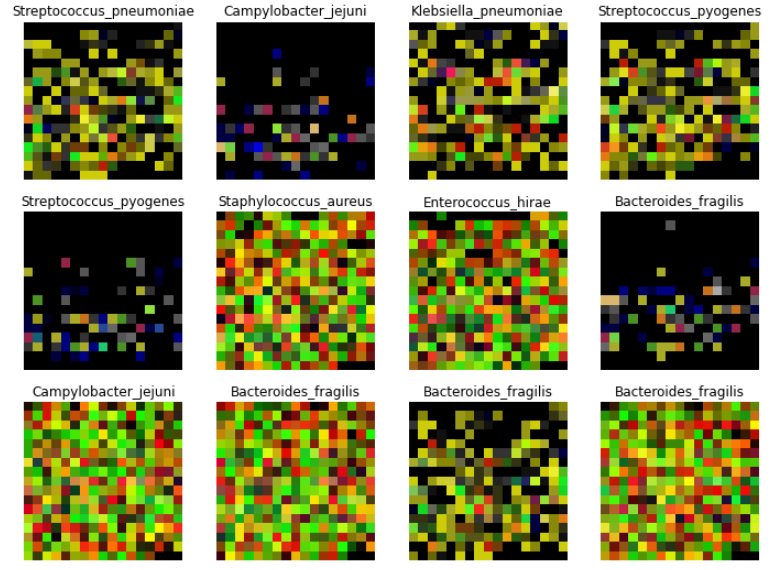

The aim of this notebook is to complete the EDA with a different approach, using image statistics to check if we can separate the images into the ten target classes also using t-sne and umap. I also created an image dataloader for FastAI vision models to experiment with different networks.

## <div style="color:white;display:fill;border-radius:5px;background-color:#e3b663;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:black;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> If you like the content or the idea, please consider support the work with an upvote👍</p></div>


# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="TOC"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Table of contents</p></div>

0. [Install](#Install)
1. [Imports](#Imports)
2. [Dataset](#Dataset) 
3. [EDA](#EDA)
4. [Rapid t-SNE analisys 2D and 3D](#Rapidt-SNEanalisys)
5. [UMAP](#UMAP)
5. [FastAI models](#FastAImodels)
6. [Training](#Training)
7. [Submission](#Submission)

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Install"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Install</p></div>
[back](#TOC)

standard imports, I often import more than I need and forget to delete it

In [ ]:
# %%capture
# !pip install google-cloud-bigquery-storage

In [ ]:
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()
# from fastbook import *


In [ ]:
from fastai.vision.all import *

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Imports"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Imports</p></div>
[back](#TOC)

In [ ]:
## Basic packages
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
sns.set_style('whitegrid')
plt.rc('image', cmap='Greys')
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from tqdm import tqdm
import plotly.express as px
import umap

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
from IPython.display import Image


# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Dataset"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Dataset</p></div>
[back](#TOC)



We just import the train and test dataset, there is an additional dataset created from the previous notebook [Turn it into a Toon!!! - TPS Feb 22](https://www.kaggle.com/austinpowers/turn-it-into-a-toon-tps-feb-22) than you can find in the kaggle datasets [Bacteria images TPS Feb 22](https://www.kaggle.com/austinpowers/bacteria-images-tps-feb-22)

In [ ]:
#import original data into pandas DataFrames
train = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv', index_col = 'row_id')
test = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv', index_col = 'row_id')

#import the image data into tensors
train_img = torch.load('../input/bacteria-images-tps-feb-22/train_X_dset_bacteria')
test_img = torch.load('../input/bacteria-images-tps-feb-22/test_dset_bacteria')

#import the labels into a Pandas DF
train_y = pd.read_csv('../input/bacteria-images-tps-feb-22/train_y_dset_bacteria.csv',index_col = 'row_id')


# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="EDA"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> EDA</p></div>
[back](#TOC)

From the previous analysis, we created 200,0000 images with size 17x17 and 3 channels - Red - Green - Blue - in the train df.
In test df, we created 100,000 images. We now import them as a tensor because it's easier and faster to manipulate them.

In [ ]:
#Shapes of the DF
shapes = train_img.shape, test_img.shape, len(train_y)
print("type and shape of the train DF: \n")
print("   type:",type(train_img))
print("   # of images:    ", shapes[0][0])
print("   size of images: ",shapes[0][1],"x",shapes[0][2], "x",shapes[0][3],"\n")
print("type and shape of the test DF: \n")
print("   type:",type(test_img))
print("   # of images:    ", shapes[1][0])
print("   size of images: ",shapes[1][1],"x",shapes[1][2], "x",shapes[1][3],"\n")
print("lenght of the labels DF:",shapes[2])

Now we are going to analyze the stats of the images to chek if there is any correlation and if we can cluster them in the ten different bacteria species. 
The stats that I created from the flattened images are:

- mean 
- standard deviation
- skew
- red mean
- green mean
- blue mean

it take a couple of minutes to complete the computation so I added a progress tracker for a coffee break!
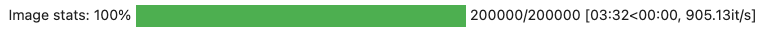
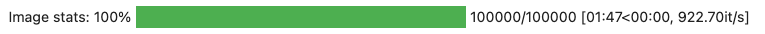

In [ ]:
from tqdm.notebook import tqdm_notebook

def image_stats(img_df):
    

    train_stat = pd.DataFrame(index=np.arange(len(img_df)),
                             columns=["img_mean", "img_std",
                                      "img_skew", "red_mean", "green_mean",
                                      "blue_mean"])

    for i in tqdm_notebook(range(len(img_df)), desc = 'Image stats'):

        #transform the image from the tensor to a numpy array
        img = img_df[i].numpy()

        #flatten the image into a vector and compute mean, std and skew
        train_stat.loc[i]["img_mean"] = np.mean(img.flatten())
        train_stat.loc[i]["img_std"] = np.std(img.flatten())
        train_stat.loc[i]["img_skew"] = skew(img.flatten())

        #compute the mean of the colors of the images
        train_stat.loc[i]["red_mean"] = np.mean(img[:,:,0].flatten())
        train_stat.loc[i]["green_mean"] = np.mean(img[:,:,1].flatten())
        train_stat.loc[i]["blue_mean"] = np.mean(img[:,:,2].flatten())
        
        
    return train_stat

In [ ]:
train_img_stat = image_stats(train_img)
train_img_stat.head(3)

In [ ]:
test_img_stat = image_stats(test_img)
test_img_stat.head(3)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.distplot(train_img_stat.img_mean, ax=ax[0], color="crimson", label="train")
sns.distplot(test_img_stat.img_mean, ax=ax[0], color="lightseagreen", label="test")
sns.distplot(train_img_stat.img_std, ax=ax[1], color="crimson", label="train")
sns.distplot(test_img_stat.img_std, ax=ax[1], color="lightseagreen", label="test")
sns.distplot(train_img_stat.img_skew, ax=ax[2], color="crimson", label="train")
sns.distplot(test_img_stat.img_skew, ax=ax[2], color="lightseagreen", label="test")


for n in range(3):
    ax[n].set_ylabel("density");
    ax[n].legend()
    
ax[0].set_title("Image means")
ax[1].set_title("Image stds")
ax[2].set_title("Image skewnesses");

We can clearly observe that the train and test datasets are identical in mean standard and skewness, wich means that the training set images is well representative of the test set.

In [ ]:
train_img_stat['target'] = train_y['target']
train_img_stat.head()

With our new image stats dataset we can now examine some properties, for example the RGB color distribution in the images in the different categories.

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
#sns.boxplot(combined_stats.gmm_cluster_label, combined_stats["rows"], ax=ax[0], palette="Greens")
sns.boxplot(x="target", y="red_mean", data=train_img_stat,ax=ax[0], palette="Reds")
ax[0].set_title("Train dataset reds sorted by bacteria")
sns.boxplot(x="target", y="green_mean", data=train_img_stat,ax=ax[1], palette="Greens")
ax[1].set_title("Train dataset greens sorted by bacteria")
sns.boxplot(x="target", y="blue_mean", data=train_img_stat,ax=ax[2], palette="Blues")
ax[2].set_title("Train dataset blues sorted by bacteria")

On the images there is in fact a big similarity between the red and the green channel. The blue looks like a good discriminatory channel for identification. We better apreciate this looking at the violin plot below about the blue channel.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax = sns.violinplot(x="target", y=train_img_stat["blue_mean"].astype('float64'), data=train_img_stat)
ax.set_title("Train dataset blue mean sorted by bacteria")

---
---
---

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Rapidt-SNEanalisys"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Rapid t-SNE analisys 2D and 3D</p></div>
[back](#TOC)

Create a t-SNE DataFrame

In [ ]:
from sklearn import manifold

flat_train_img = train_img[0:2000].reshape(2000,867)

tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(flat_train_img[:2000, :]) 

tsne_df = pd.DataFrame(np.column_stack((transformed_data, train_y[:2000])),
                       columns=["x", "y", "targets"] )


tsne_df.head(3)

Plot of t-SNE DataFrame with two components

In [ ]:
grid = sns.FacetGrid(tsne_df, hue="targets", size=8)
grid.map(plt.scatter, "x", "y").add_legend() 

In 2D we don't have much luck,not really helpful, so let's try in 3D.
 Recreate a 3D t-SNE DataFrame.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
flat_train_img1 = train_img[0:2000].reshape(2000,867)
tsne1 = manifold.TSNE(n_components=3, random_state=42)
transformed_data1 = tsne1.fit_transform(flat_train_img1[:2000, :])




tsne_df1 = pd.DataFrame(np.column_stack((transformed_data1, train_y[:2000])),
                       columns=["x", "y","z", "targets"] )

tsne_df1.head(3)

In [ ]:
df = tsne_df1
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='targets')
fig.show()

you can play around with this graph by selecting and deselecting the targets.

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="UMAP"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> UMAP</p></div>
[back](#TOC)

In [ ]:
train_sample = train.sample(20000, random_state= 42)
#train_sub = pd.read_csv('../input/new-df-kst/new_df.csv', index_col = 'row_id')

In [ ]:

embed2D= umap.UMAP(random_state = 42 ,n_components=2).fit_transform(train_sample.drop(columns='target').to_numpy())


In [ ]:
plt.figure(figsize=(20,20))
sns.scatterplot(x = embed2D[:, 0], y = embed2D[:, 1], hue='target', data=train_sample)

In [ ]:
embed3D = umap.UMAP(random_state = 42 ,n_components=3).fit_transform(train_sample.drop(columns='target').to_numpy())

In [ ]:

plt.figure(figsize=(50,50))
umap3D = px.scatter_3d(
    embed3D, x=0, y=1, z=2,
    labels={'color': 'target'},
    color= train_sample.target
    #, color_discrete_sequence=['red', 'green', 'gold', 'black','blue'],
)

umap3D.update_traces(marker_size=2)
umap3D.show()

---
---
---

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="FastAImodels"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0">FastAI models </p></div>   (when submitting it gives an error, but if you copy and edit it works great ... don't know why ... sorry)
[back](#TOC)

In order to be able to use FastAI I had to learn to create a DataLoader ... easier said than done!

The DataLoader gives you access to all the FastAI models and tricks and I have to say is quite impressive.
The inps variable is a list with inputs and targets.
The GetX function allows you to extract the image from the tensor.
The GetY of course extracts the label.
Interesting that for the DataBlock, when defining the blocks, I had to define the ImageBlock as PILImageBW ( it took me days to find out!!!)
The DataLoader is not perfect ... but a good starting point for learning

In [ ]:
# inps = L(zip(train_img, np.array(train_y['target'].tolist())))

# class GetX(ItemTransform): 
#     def encodes(self, x): 
#         self.img = x[0].numpy().astype(np.float64)
#         img = self.img.astype(np.uint8)
#         image = img # self.transform(img)
#         return (image)
    
#     #transform = T.Compose([
#         #T.ToPILImage()])#,
#         #T.ToTensor()])
        
# class GetY(ItemTransform): 
#     def encodes(self, x): return (x[1])

# dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
#                    get_x=GetX,
#                    splitter=RandomSplitter(seed=42),
#                    get_y=GetY)

In [ ]:
# dls = dblock.dataloaders(inps, bs=32)

## <div style="color:white;display:fill;border-radius:5px;background-color:#e3b663;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:black;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Why not using a batch size of 32768? IT FITS!</p></div>


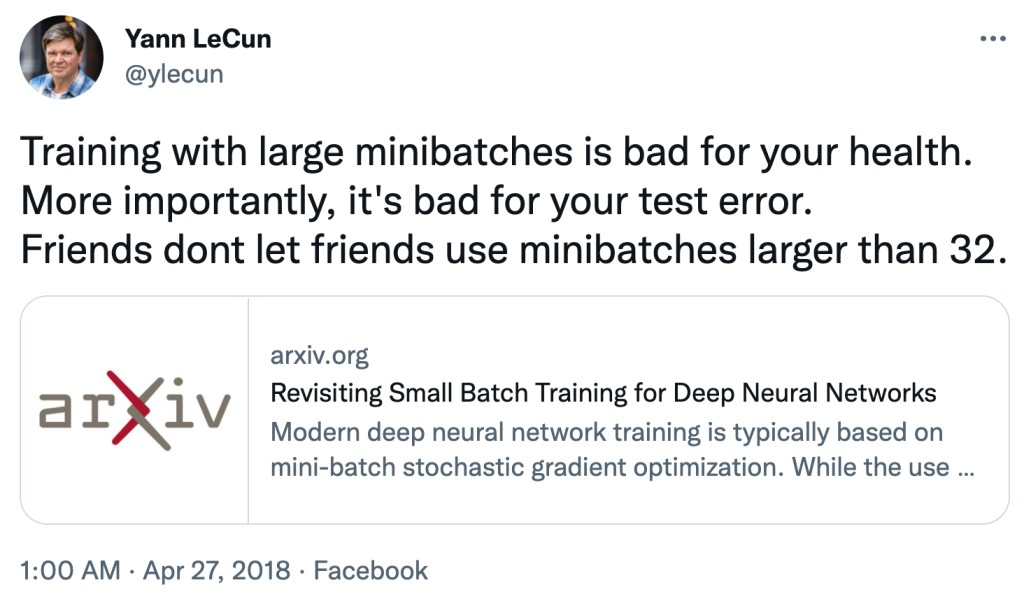

With a few experiments the batch size bs=32768 fits in the memory, but you will find out that the model learns less compared to a small batch and that the training time per epoch reaches a min of 02:05 no matter what the batch size is when you go beyond 8192.

Three good references are these two papers:
* [Revisiting Small Batch Training for Deep Neural Networks
](https://arxiv.org/abs/1804.07612) 
*[An Empirical Model of Large-Batch Training
](https://arxiv.org/abs/1812.06162)

and this article [How to get 4x speedup and better generalization using the right batch size](https://towardsdatascience.com/implementing-a-batch-size-finder-in-fastai-how-to-get-a-4x-speedup-with-better-generalization-813d686f6bdf). Enjoy the reading!


In [ ]:
# dls.show_batch(nrows=3, ncols=4, max_n=12)

In [ ]:
# x,y = dls.one_batch()
# print(f'Input shape: {x.shape}, target shape: {y.shape}.')

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Training"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Training</p></div>
[back](#TOC)

**Transfer Learning :** We start with a simple cnn learner pretrained with imagenet and we tune it for few epochs. Honestly for this kind of dataset with completely new and random images I don't expect great results. I think that a brand new model is able to have better performances.

In [ ]:
# learn = cnn_learner(dls, resnet18, metrics=accuracy)
# learn.fine_tune(6)# was 6 epochs

On this pretrained model we can see some good jumps in accuracy ... I hope to see better results in a brand new architechture.

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60,normalize=True)

The confusion matrix shows us where the model is struggling to recognise the images, the list below instead gives us all the categories that have and error above 1%.
As we can observe the results are far from great, we easily see that the major problem lies in the identification of Escherichia_coli and Streptococcus_pneumoniae. This can be better seen in the numbers here below.

In [ ]:
# interp.most_confused(min_val=100)

**Untrained model:** for an untrained model we need to use the function learner. I think that a small model for images 17x17x3 is probably more than enough to have good results.

In [ ]:
# learn1 = Learner(dls, xresnet18(n_out=10), metrics=accuracy)

What are **XResNets**?
XResNets were introduced by Tong He of Amazon Web Services, building on the idea of ResNets by introducing a ‘Bag of Tricks for Image Classification with Convolutional Neural Networks’. xResNets simply feature three different tweaks, each with different names, focusing on improving three separate convolutional steps present in the ResNet architecture. A great article is [Exploring Convolutional Neural Network Architectures with fast.ai](https://towardsdatascience.com/exploring-convolutional-neural-network-architectures-with-fast-ai-de4757eeeebf)

In [ ]:
# lr1 = learn1.lr_find()

In [ ]:
# print("the suggested lr is ",lr1[0])

## <div style="color:white;display:fill;border-radius:5px;background-color:#e3b663;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:black;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> I tried with 40 epochs and it doesn't overfit, I don't have enough GPU time left to commit, so I let you try with 40! I reached 0.9903 in accuracy! Let me know in the comments your results</p></div>


In [ ]:
# learn1.fit_one_cycle(40, lr1[0])

Nice to observe how the accuracy increases and the model doesn't overfit. I hope it doesn't because I forgot to set a seed to reproduce my results :( --- I will change it in the next versions

In [ ]:
# interp1 = ClassificationInterpretation.from_learner(learn1)
# interp1.plot_confusion_matrix(figsize=(12,12), dpi=60,normalize=True,cmap='Greens')

The results speak by themself ... between 98% and 100% accuracy. WOW!!! The WOW is if you train about 25 epochs

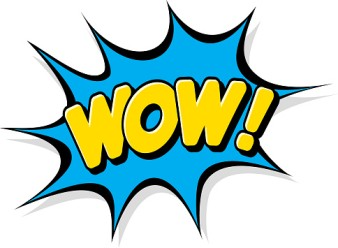

In [ ]:
# interp1.most_confused(min_val=100)

It takes a while to train it, so better save it when it's done!

In [ ]:
# learn1.save('xres18_1')

reload and improve network

In [ ]:
# to reload the model you need to create an instance before and then load the weights.
# learn1 = Learner(dls, xresnet18(n_out=10), metrics=accuracy)
# learn1.load('xres18_1')

In [ ]:
# learn1.unfreeze()

In [ ]:
# lr2 = learn1.lr_find()

In [ ]:
# learn1.freeze()
# learn1.fit_one_cycle(3, lr_max=slice(lr2[0]*1e-2,lr2[0]))

In [ ]:
# learn1.save('xres18_2')

In [ ]:
# interp2 = ClassificationInterpretation.from_learner(learn1)
# interp2.plot_confusion_matrix(figsize=(12,12), dpi=60,normalize=True)

In [ ]:
# interp2.most_confused(min_val=5)

If you need to reload a model that you previously saved on your computer you need to copy it from the /input directory where you upload it to the ./models directory where you can upload it into the notebook.

In [ ]:

# #for KAGGLE dir problem, copy the file in the working directory

# !cp ../input/tps-feb-22-xresnet18-model-fastai/xres18.pth ./models


# #reinstate the new model
# learn = Learner(dls, xresnet18(n_out=10), metrics=accuracy)
# # reload it
# learn.load('xres18')

## <div style="color:white;display:fill;border-radius:5px;background-color:#e3b663;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:black;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> If you made it down to here ... thank you very much, I hope that I was able to transfer a bit of what I learned up to now during this competition. If you have any question about the notebook I created a [discussion](https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion/307275). All the best for the competition!!!</p></div>

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Submission"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Submission</p></div>
[back](#TOC)

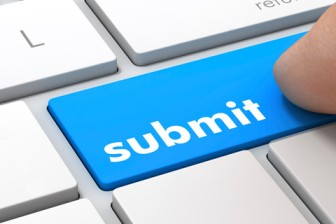

In [ ]:
# #transform the tensor of the test images
# test_img_transf = test_img.numpy().astype(np.float64)
# image_transf = test_img_transf.astype(np.uint8)

# #create the test dataloader
# test_dl = learn.dls.test_dl(image_transf)

# #get the predictions decoded
# preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

# #create the vocab to transform the predictions
# vocab_tgt = {i:dls.vocab[i] for i in range(9)}

# #create and save the submission df
# submission_df = pd.DataFrame(list(range(200000,len(test_img)+200000)),columns=['row_id'])
# submission_df['target_dec'] = decoded
# submission_df['target']= submission_df['target_dec'].map(vocab_tgt)
# submission_df = submission_df.drop(columns=['target_dec'])
# submission_df.to_csv(f'submission.csv', index=False)

In [ ]:
# submission_df.head()

---
---
---